# PRMT-1984 [HYPOTHESIS] The spread of EMIS-EMIS pending (without error) transfers is even

NB: Could this be extended to Integrated Late??

### Hypothesis
We believe that EMIS-EMIS pending transfers are spread evenly across practices
We will know this to be true when we see in the data that for these transfers, they are consistently spread cross the majority of practices rather than clustered in a smaller group of practices

 

### Subsequent questions (later hypotheses)

If transfers are in a cluster of smaller practices, what do the integrations look like for those practices? I.e. are they bad at integration and therefore makes sense that they have poor pending?

In [1]:
import pandas as pd
import numpy as np

In [2]:
transfer_file_location = "s3://prm-gp2gp-data-sandbox-dev/transfers-duplicates-hypothesis/"
transfer_files = [
    "9-2020-transfers.parquet",
    "10-2020-transfers.parquet",
    "11-2020-transfers.parquet",
    "12-2020-transfers.parquet",
    "1-2021-transfers.parquet",
    "2-2021-transfers.parquet"
]
transfer_input_files = [transfer_file_location + f for f in transfer_files]
transfers_raw = pd.concat((
    pd.read_parquet(f)
    for f in transfer_input_files
))
# This is only needed when using transfers-duplicates-hypothesis datasets
transfers_raw = transfers_raw.drop(["sending_supplier", "requesting_supplier"], axis=1)

In [3]:
asid_lookup_file = "s3://prm-gp2gp-data-sandbox-dev/asid-lookup/asidLookup-Mar-2021.csv.gz"
asid_lookup = pd.read_csv(asid_lookup_file)

In [4]:
asid_lookup.loc[asid_lookup['ASID']=='260198413015']

,ASID,NACS,OrgName,MName,PName,OrgType,PostCode
28125,260198413015,G82074,BEARSTED,EGTON MEDICAL INFORMATION SYSTEMS LTD (EMIS),EMIS Web,GP Practice,ME14 4DS


In [5]:
# Given the findings in PRMT-1742 - many duplicate EHR errors are misclassified, the below reclassifies the relevant data
successful_transfers_bool = transfers_raw['request_completed_ack_codes'].apply(lambda x: True in [(np.isnan(i) or i==15) for i in x])
transfers = transfers_raw.copy()
transfers.loc[successful_transfers_bool, "status"] = "INTEGRATED"

In [6]:
pending_sender_error_codes=[6,7,10,24,30,23,14,99]
transfers_with_pending_sender_code_bool=transfers['sender_error_code'].isin(pending_sender_error_codes)
transfers_with_pending_with_error_bool=transfers['status']=='PENDING_WITH_ERROR'
transfers_which_need_pending_to_failure_change_bool=transfers_with_pending_sender_code_bool & transfers_with_pending_with_error_bool
transfers.loc[transfers_which_need_pending_to_failure_change_bool,'status']='FAILED'

In [7]:
eight_days_in_seconds=8*24*60*60
transfers_after_sla_bool=transfers['sla_duration']>eight_days_in_seconds
transfers_with_integrated_bool=transfers['status']=='INTEGRATED'
transfers_integrated_late_bool=transfers_after_sla_bool & transfers_with_integrated_bool
transfers.loc[transfers_integrated_late_bool,'status']='INTEGRATED LATE'

In [8]:
# Supplier name mapping
supplier_renaming = {
    "EGTON MEDICAL INFORMATION SYSTEMS LTD (EMIS)":"EMIS",
    "IN PRACTICE SYSTEMS LTD":"Vision",
    "MICROTEST LTD":"Microtest",
    "THE PHOENIX PARTNERSHIP":"TPP",
    None: "Unknown"
}

lookup = asid_lookup[["ASID", "MName", "NACS"]]

transfers = transfers.merge(lookup, left_on='requesting_practice_asid',right_on='ASID',how='left').drop("NACS", axis=1)
transfers = transfers.rename({'MName': 'requesting_supplier', 'ASID': 'requesting_supplier_asid'}, axis=1)
transfers = transfers.merge(lookup, left_on='sending_practice_asid',right_on='ASID',how='left')
transfers = transfers.rename({'MName': 'sending_supplier', 'ASID': 'sending_supplier_asid', 'NACS': 'sending_ods_code'}, axis=1)

transfers["sending_supplier"] = transfers["sending_supplier"].replace(supplier_renaming.keys(), supplier_renaming.values())
transfers["requesting_supplier"] = transfers["requesting_supplier"].replace(supplier_renaming.keys(), supplier_renaming.values())

### Select just relevant data: EMIS-EMIS

In [9]:
both_suppliers_EMIS_bool=(transfers['requesting_supplier']=='EMIS') & (transfers['sending_supplier']=='EMIS')

relevant_transfers=transfers.loc[both_suppliers_EMIS_bool]

### Pivot table of practice vs status volumes

In [10]:
practice_status_table=pd.pivot_table(relevant_transfers,index='requesting_practice_asid',columns='status',values='conversation_id',aggfunc='count').fillna(0)
practice_status_table['TOTAL']=practice_status_table.sum(axis=1)
practice_status_pc=100*practice_status_table.div(practice_status_table['TOTAL'],axis=0).drop('TOTAL',axis=1)
practice_status_pc.columns=practice_status_pc.columns + " %"
practice_status_table=pd.concat([practice_status_table,practice_status_pc],axis=1)

0.1     0.000000
0.2     0.000000
0.3     0.000000
0.4     0.000000
0.5     0.196078
0.6     0.480769
0.7     0.735294
0.8     1.123596
0.9     2.272727
1.0    96.250000
Name: PENDING %, dtype: float64

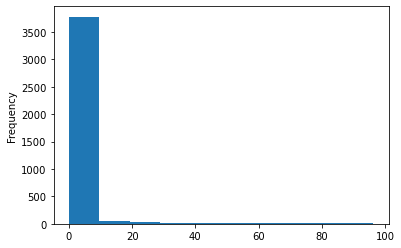

In [11]:
practice_status_table['PENDING %'].plot.hist()
practice_status_table['PENDING %'].quantile(np.arange(0.1, 1.1, 0.1))

<AxesSubplot:xlabel='TOTAL', ylabel='PENDING %'>

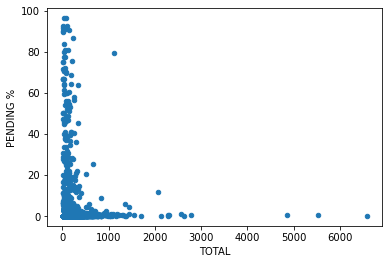

In [12]:
practice_status_table.plot.scatter(x='TOTAL',y='PENDING %')

<AxesSubplot:xlabel='TOTAL', ylabel='PENDING %'>

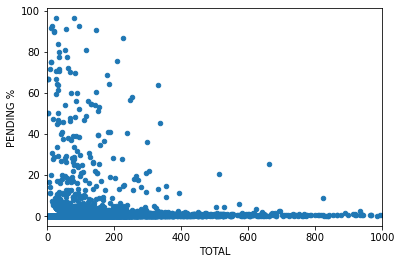

In [13]:
practice_status_table.plot.scatter(x='TOTAL',y='PENDING %',xlim=[0,1000])

<AxesSubplot:xlabel='PENDING %', ylabel='INTEGRATED LATE %'>

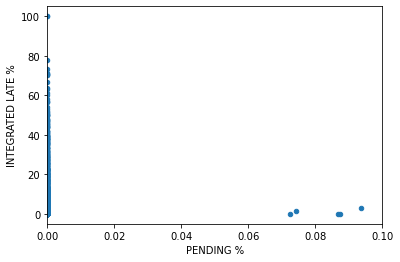

In [14]:
practice_status_table.plot.scatter(x='PENDING %',y='INTEGRATED LATE %',xlim=[0,0.1])

In [15]:
practice_status_table[["FAILED %","INTEGRATED %","INTEGRATED LATE %","PENDING %","PENDING_WITH_ERROR %"]].corr()

status,FAILED %,INTEGRATED %,INTEGRATED LATE %,PENDING %,PENDING_WITH_ERROR %
status,,,,,
FAILED %,1.000000,-0.408097,0.089774,0.380024,-0.000528
INTEGRATED %,-0.408097,1.000000,-0.813560,-0.703807,-0.089285
INTEGRATED LATE %,0.089774,-0.813560,1.000000,0.193205,-0.006813
PENDING %,0.380024,-0.703807,0.193205,1.000000,0.006569
PENDING_WITH_ERROR %,-0.000528,-0.089285,-0.006813,0.006569,1.000000


<AxesSubplot:xlabel='PENDING %', ylabel='FAILED %'>

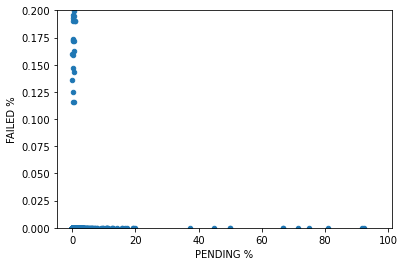

In [16]:
practice_status_table.plot.scatter(x='PENDING %',y='FAILED %',ylim=[0,0.2])

<AxesSubplot:xlabel='TOTAL', ylabel='PENDING'>

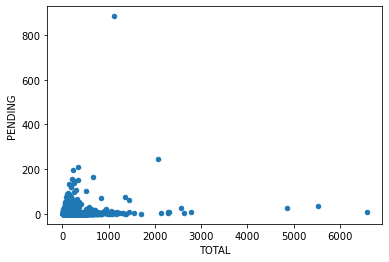

In [17]:
practice_status_table.plot.scatter(x='TOTAL',y='PENDING')

In [18]:
practice_status_table.corr()

status,FAILED,INTEGRATED,INTEGRATED LATE,PENDING,PENDING_WITH_ERROR,TOTAL,FAILED %,INTEGRATED %,INTEGRATED LATE %,PENDING %,PENDING_WITH_ERROR %
status,,,,,,,,,,,
FAILED,1.000000,0.312707,0.588573,0.401717,0.298665,0.486602,0.320502,-0.167849,0.062875,0.148646,-0.006586
INTEGRATED,0.312707,1.000000,0.131090,0.010344,0.598428,0.960091,-0.059751,0.201425,-0.177385,-0.129491,-0.019849
INTEGRATED LATE,0.588573,0.131090,1.000000,0.144810,0.256682,0.390589,0.038380,-0.274922,0.356691,0.037299,-0.003561
PENDING,0.401717,0.010344,0.144810,1.000000,0.057123,0.128827,0.203901,-0.377898,0.117077,0.519150,0.000549
PENDING_WITH_ERROR,0.298665,0.598428,0.256682,0.057123,1.000000,0.626996,-0.011571,0.026047,-0.035607,-0.030770,0.180590
TOTAL,0.486602,0.960091,0.390589,0.128827,0.626996,1.000000,-0.022230,0.085756,-0.065706,-0.067798,-0.018520
FAILED %,0.320502,-0.059751,0.038380,0.203901,-0.011571,-0.022230,1.000000,-0.408097,0.089774,0.380024,-0.000528
INTEGRATED %,-0.167849,0.201425,-0.274922,-0.377898,0.026047,0.085756,-0.408097,1.000000,-0.813560,-0.703807,-0.089285
INTEGRATED LATE %,0.062875,-0.177385,0.356691,0.117077,-0.035607,-0.065706,0.089774,-0.813560,1.000000,0.193205,-0.006813


In [19]:
practice_status_table['PENDING'].max()/practice_status_table['PENDING'].sum()

0.0748771810943588

In [41]:
practice_status_table=practice_status_table.sort_values(by='PENDING',ascending=False)
full_practice_status_table=asid_lookup.merge(practice_status_table, left_on='ASID', right_index=True, how='right')
full_practice_status_table=full_practice_status_table.drop(['MName','PName'],axis=1)
full_practice_status_table.head()


,ASID,NACS,OrgName,OrgType,PostCode,FAILED,INTEGRATED,INTEGRATED LATE,PENDING,PENDING_WITH_ERROR,TOTAL,FAILED %,INTEGRATED %,INTEGRATED LATE %,PENDING %,PENDING_WITH_ERROR %
33038,615075629043,D82088,UEA MEDICAL CENTRE,GP Practice,NR4 7TJ,123.0,36.0,73.0,884.0,1.0,1117.0,11.011638,3.222919,6.535363,79.140555,0.089526
33754,669024222046,P81002,LANCASTER MEDICAL PRACTICE,GP Practice,LA1 1PN,47.0,755.0,1013.0,244.0,1.0,2060.0,2.281553,36.650485,49.174757,11.844660,0.048544
28125,260198413015,G82074,BEARSTED,GP Practice,ME14 4DS,44.0,73.0,2.0,211.0,0.0,330.0,13.333333,22.121212,0.606061,63.939394,0.000000
31980,540917834041,K81638,BURMA HILL PRACTICE,GP Practice,RG40 1PH,26.0,1.0,2.0,197.0,1.0,227.0,11.453744,0.440529,0.881057,86.784141,0.440529
36076,847520267018,G85023,LEWISHAM MEDICAL CENTRE,GP Practice,SE13 5PJ,9.0,487.0,0.0,166.0,0.0,662.0,1.359517,73.564955,0.000000,25.075529,0.000000


In [52]:
def generate_gp_table(gp_asid): 
    gp_practice_transfers=transfers.loc[transfers['requesting_practice_asid']==gp_asid]
    gp_practice_transfers['Month']=gp_practice_transfers['date_requested'].dt.to_period('M')

    gp_totals=pd.pivot_table(gp_practice_transfers,index='Month',columns='status',values='conversation_id',aggfunc='count').fillna(0)
    gp_percentages=pd.pivot_table(gp_practice_transfers,index='Month',columns='status',values='conversation_id',aggfunc='count').fillna(0).div(gp_practice_transfers['Month'].value_counts(),axis=0)
    gp_percentages=(100*gp_percentages).round(2)
    gp_percentages.columns='% '+gp_percentages.columns

    return pd.concat([gp_totals, gp_percentages], axis=1)



In [58]:

writer = pd.ExcelWriter('prmt-1984-emis-emis-practice-level-statuses.xlsx', engine='xlsxwriter')

asid_of_interest=full_practice_status_table.head(10)['ASID'].values
full_practice_status_table.to_excel(writer, sheet_name='overview')
asid_of_interest.stream()
[generate_gp_table(gp_asid).to_excel(writer,sheet_name=gp_asid) for gp_asid in asid_of_interest] 
writer.save()
# generate_gp_table('669024222046')

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

status,% FAILED,% INTEGRATED,% INTEGRATED LATE,% PENDING,% PENDING_WITH_ERROR
2020-09,1.97,44.08,50.45,3.50,0.00
2020-10,1.53,35.44,61.11,1.92,0.00
2020-11,3.06,16.33,63.95,16.33,0.34
2020-12,3.77,20.13,26.42,49.69,0.00
2021-01,10.34,16.67,29.31,43.68,0.00
2021-02,10.50,20.00,25.50,44.00,0.00
